In [1]:
import os
import pandas as pd

from QEDV_lib import QuantumError

# Base folder containing the numbered subfolders
base_folder = ""

# List to store dataframes
dfs = []

# Loop through folders 1-10
for i in range(11, 16):
    folder_path = os.path.join(base_folder, str(i))
    
    # Check if folder exists
    if os.path.isdir(folder_path):
        # Loop through all .pkl files in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".pkl"):
                file_path = os.path.join(folder_path, file)
                df = pd.read_pickle(file_path)  # Read the pickle file
                dfs.append(df)

# Concatenate all dataframes
if dfs:
    final_df = pd.concat(dfs, ignore_index=True)
    print(final_df)
else:
    print("No pickle files found.")

        Error Rate  Dimension  Solvable     rlimit          time  Brute  \
0            0.001          3      True          0  2.426000e-06  False   
1            0.001          3      True          0  4.320000e-07  False   
2            0.001          3      True          0  2.309998e-07  False   
3            0.001          3      True          0  2.110000e-07  False   
4            0.001          3      True          0  1.940002e-07  False   
...            ...        ...       ...        ...           ...    ...   
265675       0.500         49     False  151484977  8.434403e-01  False   
265676       0.500         49     False  151520599  8.767228e-01  False   
265677       0.500         49     False  151556221  8.361357e-01  False   
265678       0.500         49     False  151591843  8.418999e-01  False   
265679       0.500         49     False  151627465  8.327136e-01  False   

        BruteTime                                        trials_test  \
0               0  <QEDV_li

In [2]:
df = final_df

In [4]:
# Extract number of qubits from the trials_test object
df["num_qubits"] = df["trials_test"].apply(lambda x: len(x.qubits) if hasattr(x, "qubits") else None)
# Remove rows where num_qubits is 0
df = df[df["num_qubits"] != 0]

# Reset index after filtering (optional)
df = df.reset_index(drop=True)

# Verify that no zero values remain
print(df["num_qubits"].unique())  # Should not contain 0

# Compute correlation between num_qubits and time
correlation = df["num_qubits"].corr(df["time"])
print("Correlation between number of errors and time:", correlation)


[   1    3    2 ... 1269 1243 1249]
Correlation between number of errors and time: 0.6041398899005956


In [5]:
df.groupby("Error Rate")['time'].mean()

Error Rate
0.001    0.435847
0.010    0.317319
0.050    0.284507
0.100    0.277690
0.200    0.274325
0.250    0.273977
0.300    0.273726
0.350    0.273703
0.500    0.272796
Name: time, dtype: float64

In [6]:
import numpy as np
def calcDifficulty(error, len):
    matrix = np.zeros((len,len))
    for qubit in error.qubits:
        row = qubit % len
        col = qubit // len
        matrix[row][col] = 1
    n = len
    
    if n == 0: return []
    
    # Directions for up, down, left, right, and diagonals
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),   # Up, Down, Left, Right
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]  # Diagonals
    
    visited = [[False] * n for _ in range(n)]
    chains = []  # To store the lengths of all chains

    def dfs(x, y):
        stack = [(x, y)]
        visited[x][y] = True
        length = 1  # Count the initial 1
        
        while stack:
            cx, cy = stack.pop()
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                # Check if the neighbor is within bounds and a 1 that hasn't been visited
                if 0 <= nx < n and 0 <= ny < n and not visited[nx][ny] and matrix[nx][ny] == 1:
                    visited[nx][ny] = True
                    stack.append((nx, ny))
                    length += 1
        return length

    # Traverse all cells in the matrix
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 1 and not visited[i][j]:
                # Run DFS to find the chain length
                chain_length = dfs(i, j)
                chains.append(chain_length)

    return chains

In [7]:
from QEDV_lib import QuantumError
matrix = [
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
]

calcDifficulty(QuantumError({1,2,8}),3)  # Output: 5 (longest connected chain of 1’s)


[2, 1]

In [9]:
def getDiff(trial_test, trial_dim):
    # Example implementation (adjust based on your actual function)
    lis = calcDifficulty(trial_test, trial_dim)
    sum = 0
    for entry in lis:
        sum += entry**2
    return sum

def maxLength(trials_test, trials_dim):
    result = calcDifficulty(trials_test, trials_dim)
    if result:
        return max(result)
    return 0
# Track progress during apply()
def getDiff_with_progress(row, index, total):
    if index % 100 == 0:  # Print progress every 100 rows
        print(f"Processing row {index}/{total}...")
    return getDiff(row['trials_test'], row['trial_dim'])

def maxLength_with_progress(row, index, total):
    if index % 100 == 0:
        print(f"Processing row {index}/{total}...")
    return maxLength(row['trials_test'], row['trial_dim'])

total_rows = len(df)

df['diff'] = [getDiff_with_progress(row, i, total_rows) for i, row in df.iterrows()]
df['diff_2'] = [maxLength_with_progress(row, i, total_rows) for i, row in df.iterrows()]



Processing row 0/243703...
Processing row 100/243703...
Processing row 200/243703...
Processing row 300/243703...
Processing row 400/243703...
Processing row 500/243703...
Processing row 600/243703...
Processing row 700/243703...
Processing row 800/243703...
Processing row 900/243703...
Processing row 1000/243703...
Processing row 1100/243703...
Processing row 1200/243703...
Processing row 1300/243703...
Processing row 1400/243703...
Processing row 1500/243703...
Processing row 1600/243703...
Processing row 1700/243703...
Processing row 1800/243703...
Processing row 1900/243703...
Processing row 2000/243703...
Processing row 2100/243703...
Processing row 2200/243703...
Processing row 2300/243703...
Processing row 2400/243703...
Processing row 2500/243703...
Processing row 2600/243703...
Processing row 2700/243703...
Processing row 2800/243703...
Processing row 2900/243703...
Processing row 3000/243703...
Processing row 3100/243703...
Processing row 3200/243703...
Processing row 3300/24

In [10]:
correlation = df['diff'].corr(df['time'])
correlation2 = df['diff_2'].corr(df['time'])

print("With length of chain squared", correlation, "With max length", correlation2)

With length of chain squared 0.2783115809993895 With max length 0.2672819506306888


In [11]:
df['trial_dim'].unique()


array([ 7, 11, 15, 17, 19, 21, 23, 25, 27, 29, 31, 35, 37, 39, 41, 43, 45,
       47, 49,  5,  9, 13, 33,  3], dtype=int64)

In [12]:
df.groupby('trial_dim')[['time','num_qubits']].corr().unstack().iloc[:,1]


trial_dim
3    -0.184335
5    -0.162927
7    -0.144378
9    -0.116779
11   -0.093717
13   -0.074956
15   -0.107112
17   -0.039157
19   -0.039478
21   -0.068125
23   -0.055141
25    0.003365
27   -0.036458
29   -0.049689
31   -0.010440
33   -0.010311
35   -0.010247
37   -0.014921
39    0.007052
41   -0.015607
43    0.006604
45   -0.024345
47   -0.008572
49   -0.007979
Name: (time, num_qubits), dtype: float64

In [13]:
# Compute overall correlation (without grouping)
overall_corr_diff = df["diff"].corr(df["time"])
overall_corr_diff2 = df["diff_2"].corr(df["time"])
overall_corr_qubits = df["num_qubits"].corr(df["time"])

print("Overall Correlation:")
print("diff vs. time:", overall_corr_diff)
print("diff_2 vs. time:", overall_corr_diff2)
print("num_qubits vs. time:", overall_corr_qubits)


Overall Correlation:
diff vs. time: 0.2783115809993895
diff_2 vs. time: 0.2672819506306888
num_qubits vs. time: 0.6041398899005956


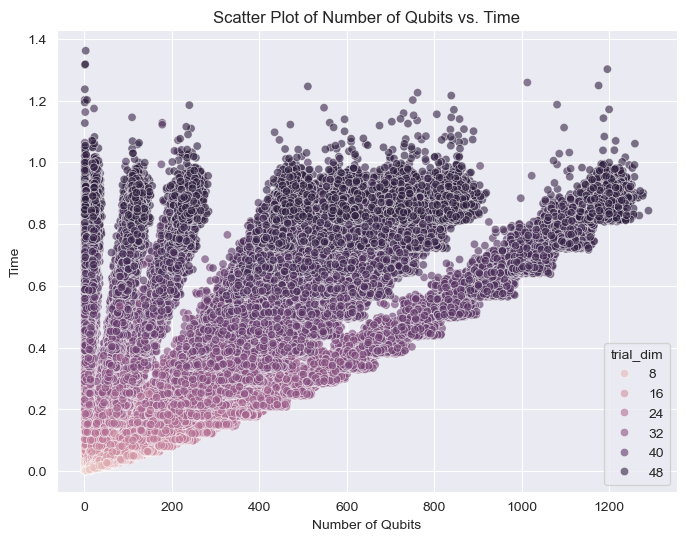

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["num_qubits"], y=df["time"], hue=df["trial_dim"], alpha=0.6)

# Add labels and title
plt.xlabel("Number of Qubits")
plt.ylabel("Time")
plt.title("Scatter Plot of Number of Qubits vs. Time")

# Show the plot
plt.show()


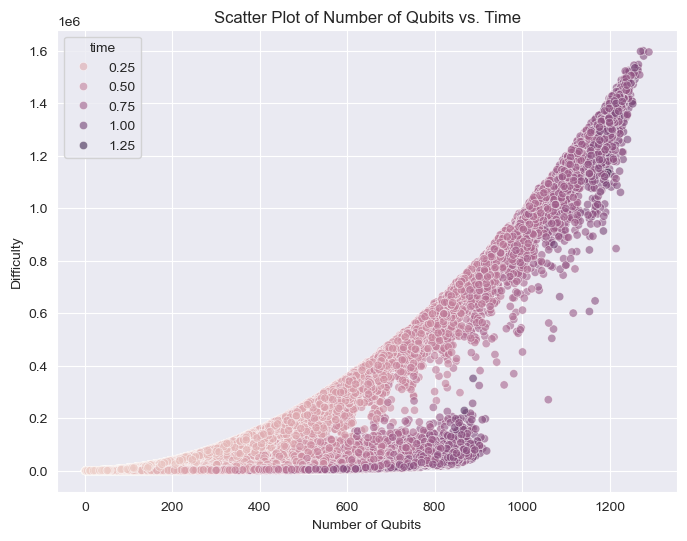

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["num_qubits"], y=df["diff"], hue=df["time"], alpha=0.6)

# Add labels and title
plt.xlabel("Number of Qubits")
plt.ylabel("Difficulty")
plt.title("Scatter Plot of Number of Qubits vs. Time")

# Show the plot
plt.show()


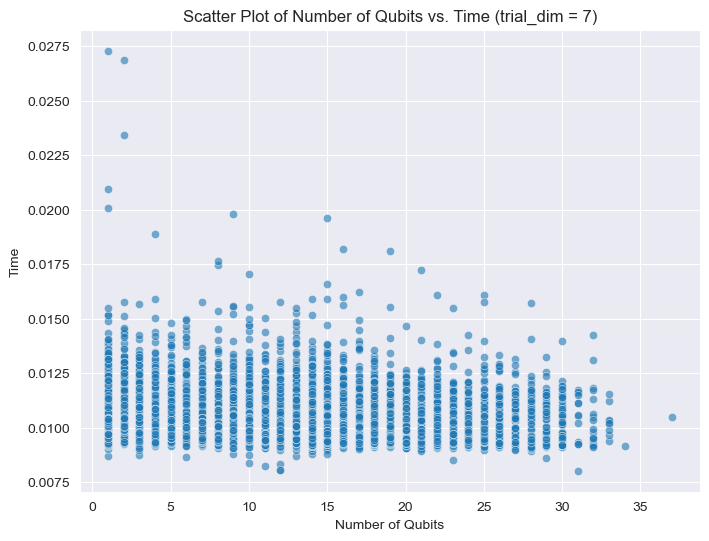

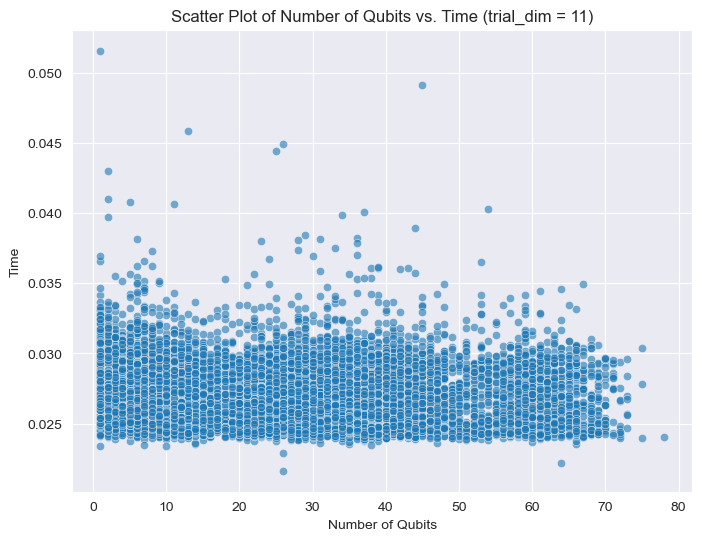

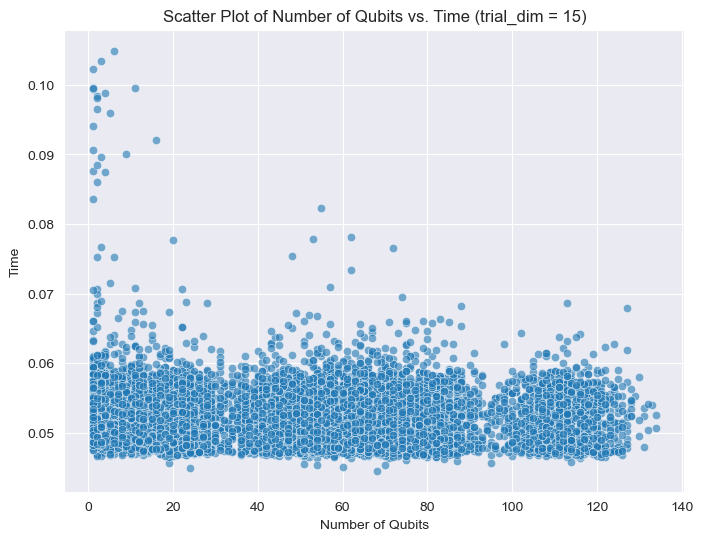

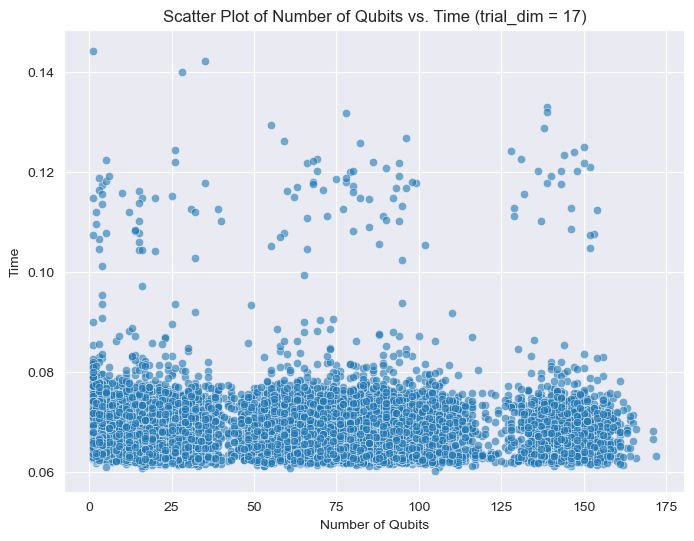

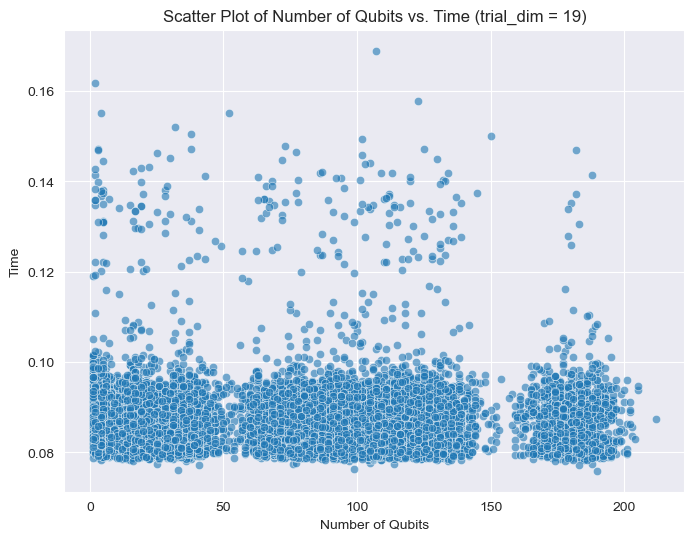

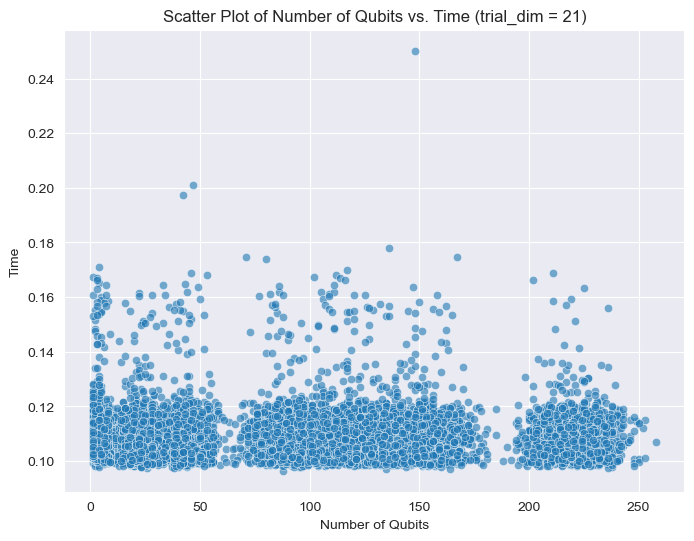

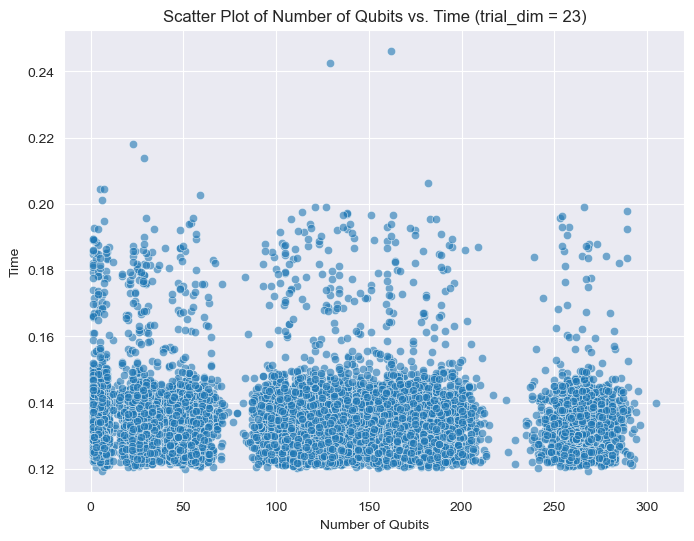

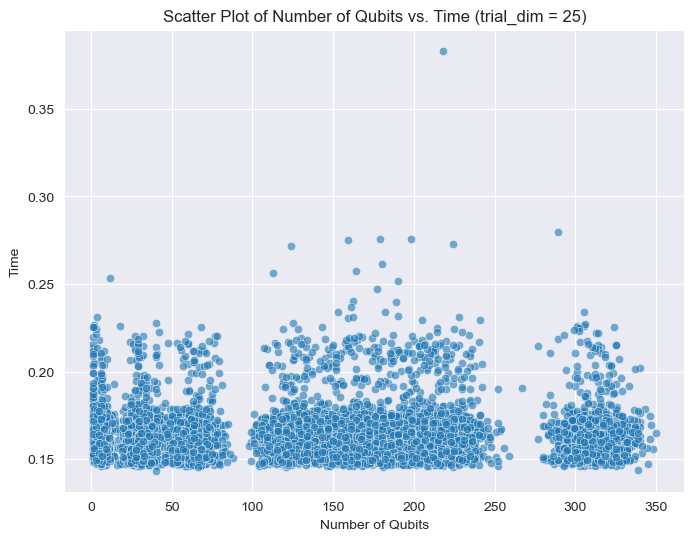

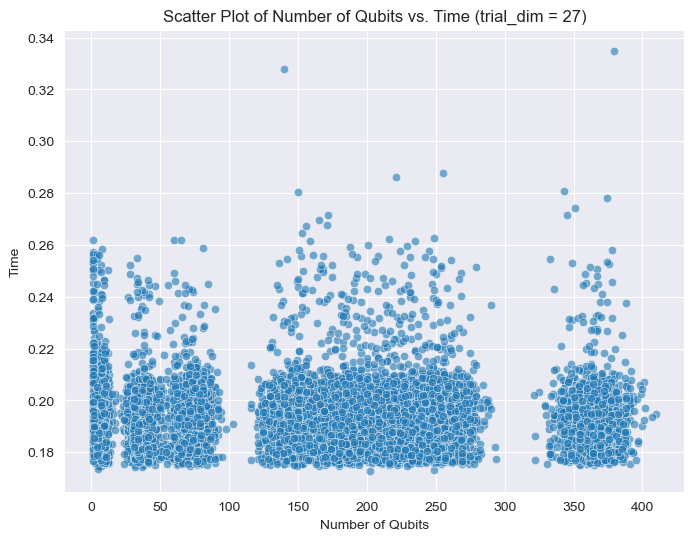

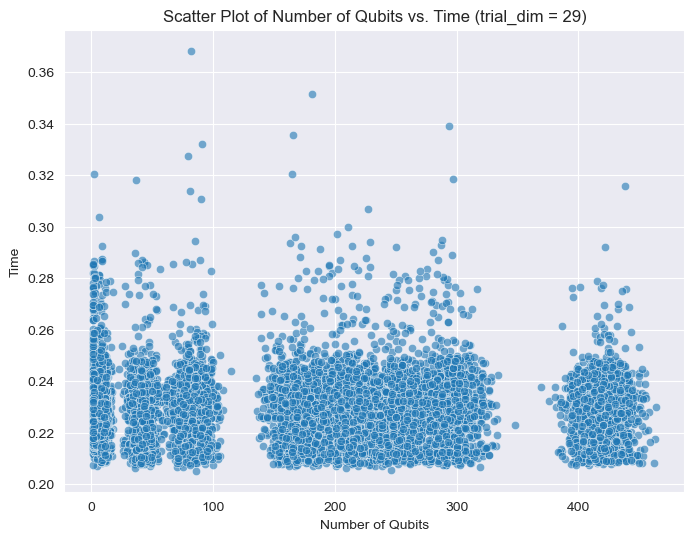

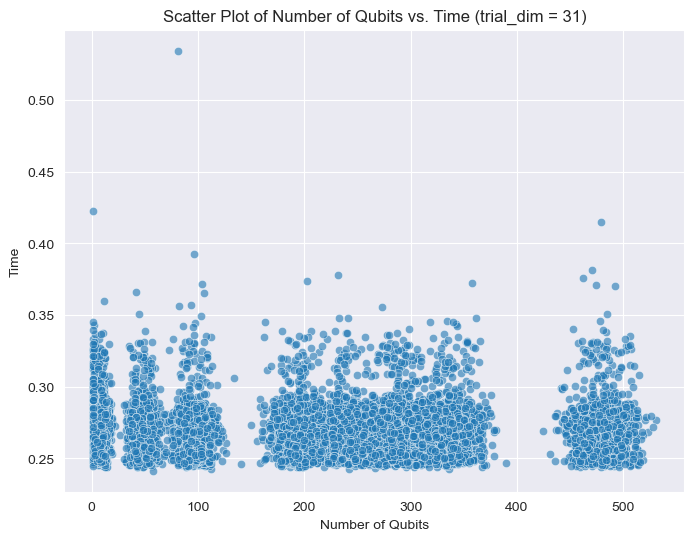

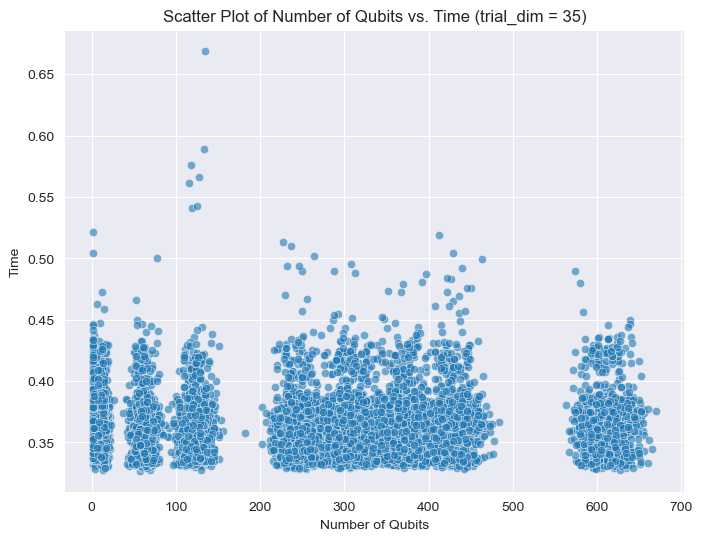

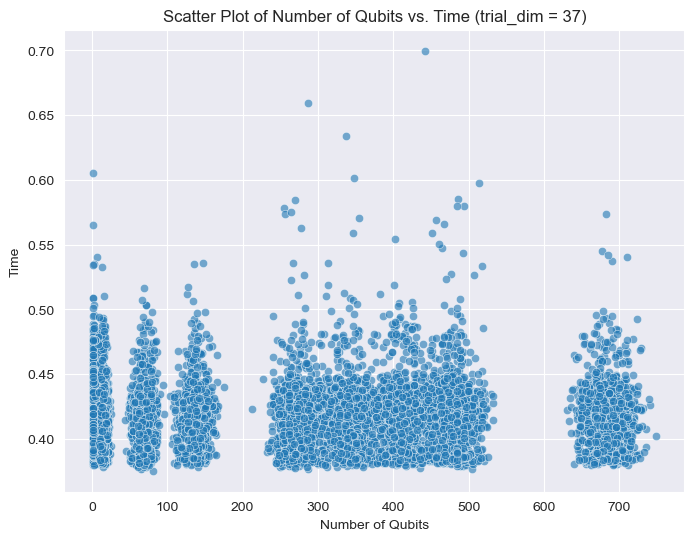

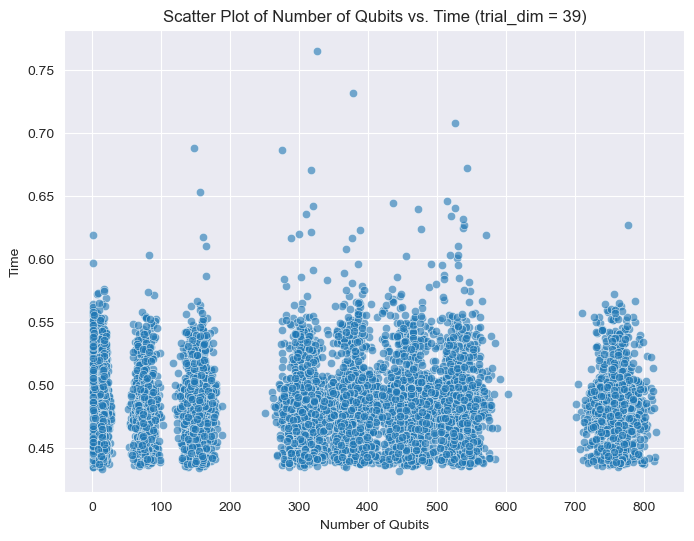

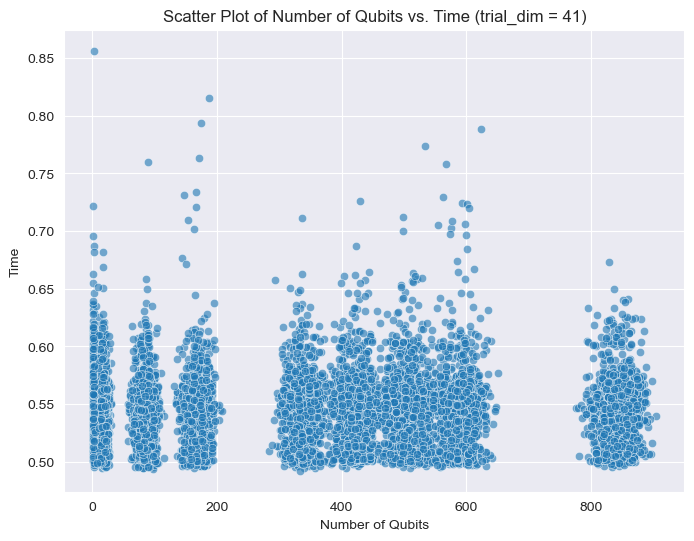

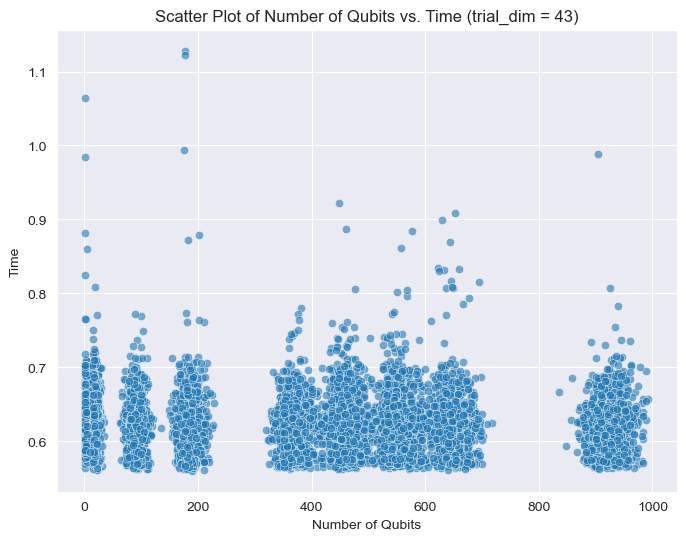

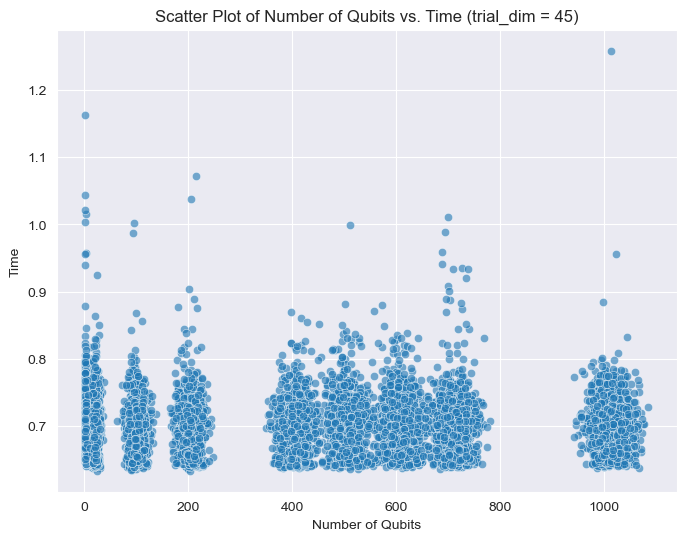

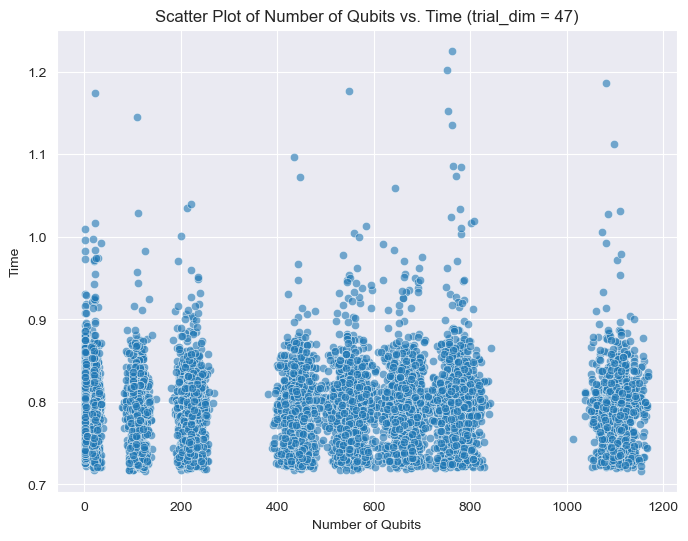

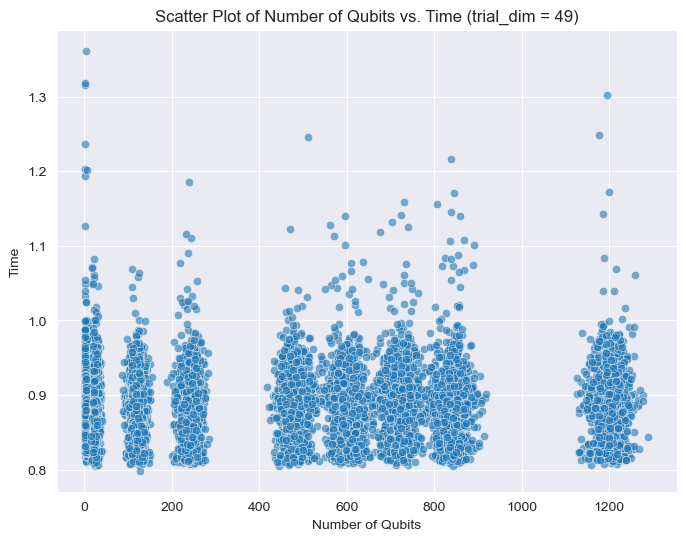

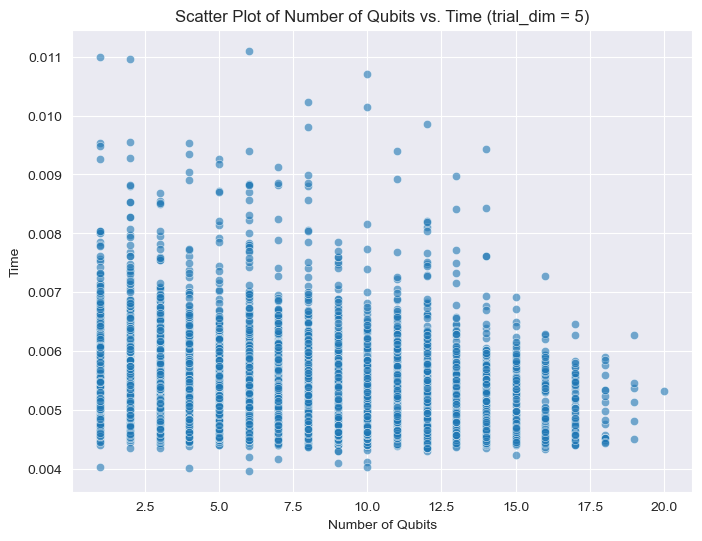

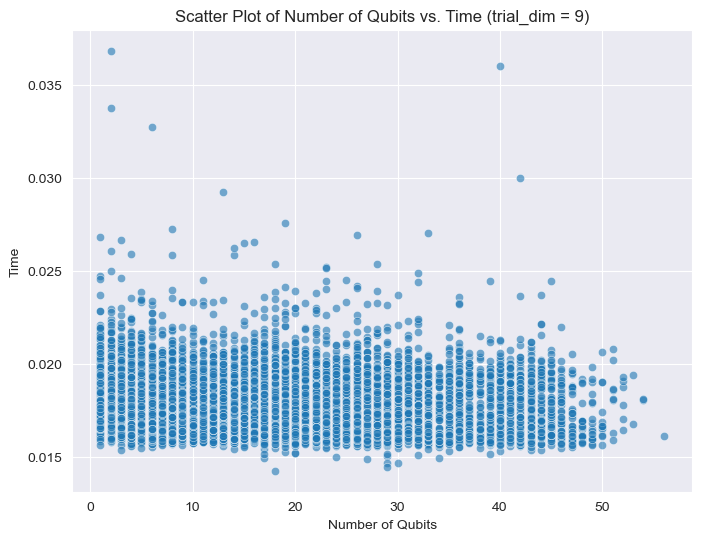

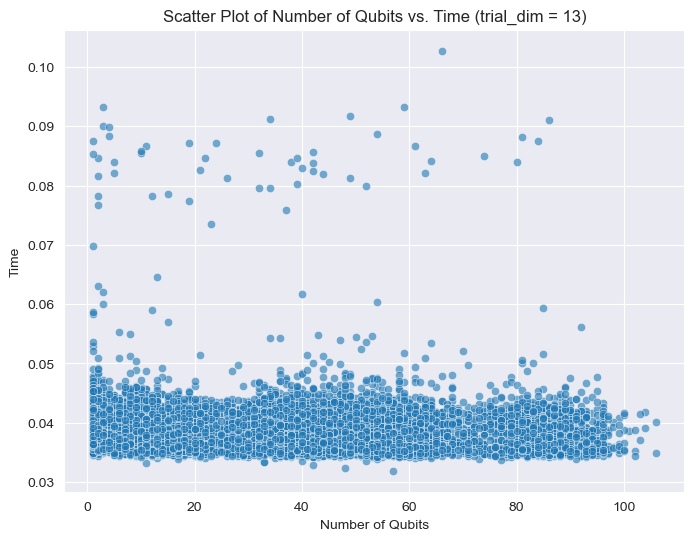

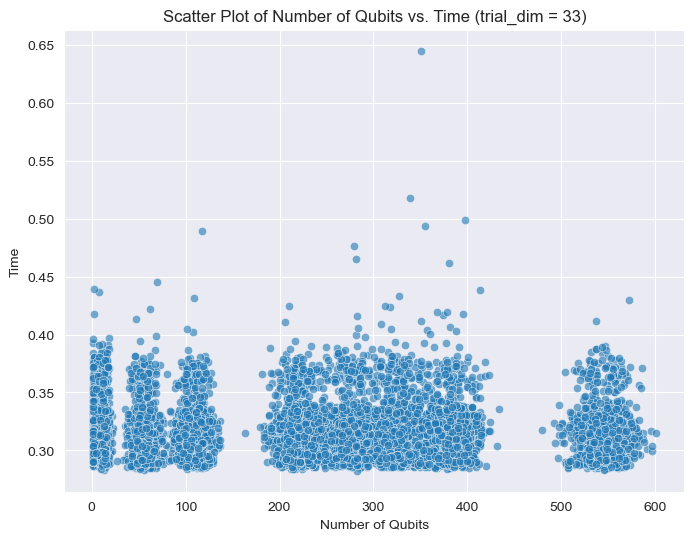

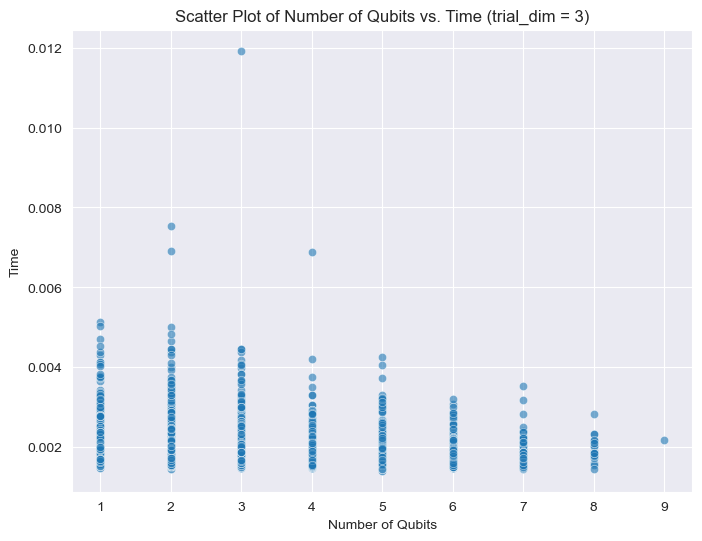

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the specific trial_dim value you want to plot
selected_trial_dims = df['trial_dim'].unique()


for trial_dim_value in selected_trial_dims:
    # Filter the DataFrame for the specific trial_dim
    df_filtered = df[df["trial_dim"] == trial_dim_value]

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_filtered["num_qubits"], y=df_filtered["time"], alpha=0.6)

    # Add labels and title
    plt.xlabel("Number of Qubits")
    plt.ylabel("Time")
    plt.title(f"Scatter Plot of Number of Qubits vs. Time (trial_dim = {trial_dim_value})")

    # Show the plot
    plt.show()
